In [1]:
import numpy as np 
import nibabel as nib 
import matplotlib.pyplot as plt 
import nilearn.plotting as niplt
%matplotlib inline
import os 
import seaborn as sns 
from scipy.special import softmax 
import pandas as pd 

In [2]:
black_subs=['sub-300', 'sub-304', 'sub-293', 'sub-273', 'sub-265', 'sub-307', 'sub-283', 'sub-275', 
'sub-291', 'sub-297', 'sub-303', 'sub-294', 'sub-286', 'sub-282', 'sub-310', 'sub-302', 'sub-312', 
'sub-301', 'sub-287', 'sub-298', 'sub-313', 'sub-285', 'sub-292', 'sub-311', 'sub-267', 'sub-295', 
'sub-305', 'sub-274', 'sub-290', 'sub-288', 'sub-281', 'sub-276', 'sub-277', 'sub-299', 'sub-308',
 'sub-272', 'sub-284', 'sub-289', 'sub-280', 'sub-309', 'sub-306', 'sub-296', 'sub-127', 'sub-279', 
 'sub-315', 'sub-314']
slumlordreach_subs=['sub-145', 'sub-143', 'sub-016', 'sub-142', 'sub-141', 'sub-133', 'sub-140', 'sub-136', 
'sub-084', 'sub-135', 'sub-137', 'sub-138', 'sub-111', 'sub-106', 'sub-134', 'sub-132', 'sub-144']
def get_result_dataset(dataset,rep_name,normalize_isc=True):
    results=[]
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        if 'layer' not in rep_name and 'ling' not in rep_name:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+story+"_"+rep_name+"/"
        else:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+rep_name+"/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI.npy')
        for sub in subs:
            results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            noise_ceiling_parcels=np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy')
            results_sub=np.zeros((20,))
            noise_sub=np.zeros((20,))
            for roi in range(20):
                results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean() 
                noise_sub[roi]=noise_ceiling_parcels[np.where(roi_mapping==roi+1)].mean()
            #results_story.append(-1*np.log(results_sub/noise_sub))
            results_story.append((results_sub/noise_sub)*100.0)
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    results=np.concatenate(results,axis=0)
    results[np.isnan(results)]=0.0
    return results 
    #return results*-1 
    #if normalize_isc:
    #    return (np.concatenate(results,axis=0)/noise_ceiling)*100.0
    #else:
    #    return np.concatenate(results,axis=0)

In [3]:
layerwise=np.asarray([get_result_dataset(['black','slumlordreach'],'layer_'+str(i)+"_activations") for i in range(12)]).mean(axis=1)
zwise=np.asarray([get_result_dataset(['black','slumlordreach'],'layer_'+str(i)+"_z_representations") for i in range(12)]).mean(axis=1)

In [29]:
#rois=['PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC','HG']
rois=['HG','PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC']
roi_names=['L_'+roi for roi in rois]+['R_'+roi for roi in rois] 

def softmax(x, tau=1.0):
    e_x = np.exp(x / tau)
    return e_x / e_x.sum()

def make_ridge_plot(data,n_points=10000,tau=1.0,smax=True,bw_adjust=2):
    x=[]
    g=[]
    
    for roi in range(20):
        if smax:
            p=softmax(data[:,roi],tau=tau)
        else:
            p=data[:,roi].copy()
            p[p<0]=0.0
            p/=np.sum(p)
            p[np.isnan(p)]=0.0
            if np.sum(p)==0.0:
                p[:]=1.0/len(p)
       
        points=np.random.choice(np.arange(12),size=n_points,p=p)
        for p in points:
            x.append(p)
            g.append(roi_names[roi])
    x=np.asarray(x)
    g=np.asarray(g)
    #g = np.tile(roi_names, n_points)
    df = pd.DataFrame(dict(x=x, g=g))
    #m = df.g.map(ord)
    #df["x"] += m
    # Initialize the FacetGrid object
    #pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    pal=sns.mpl_palette('tab10',n_colors=10)
    g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "x",
        bw_adjust=bw_adjust, clip_on=False,
        fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=bw_adjust)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .9, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, "x")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.0009)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(xticks=list(range(12)))
    g.set(yticks=[])
    g.despine(bottom=True, left=True)

        

    

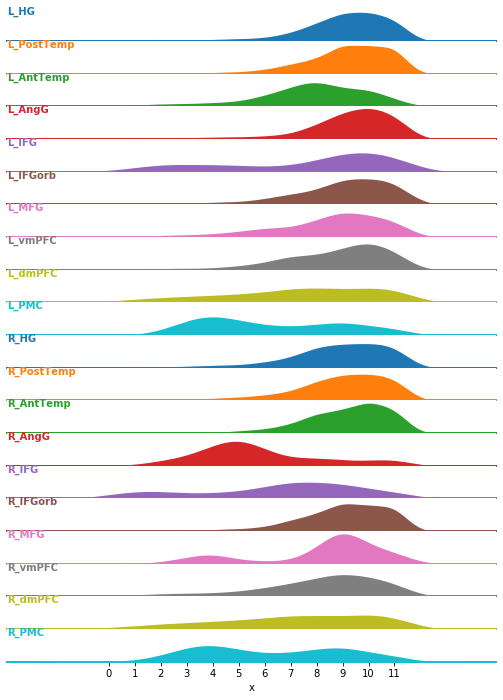

In [42]:

make_ridge_plot(layerwise,tau=3.0)


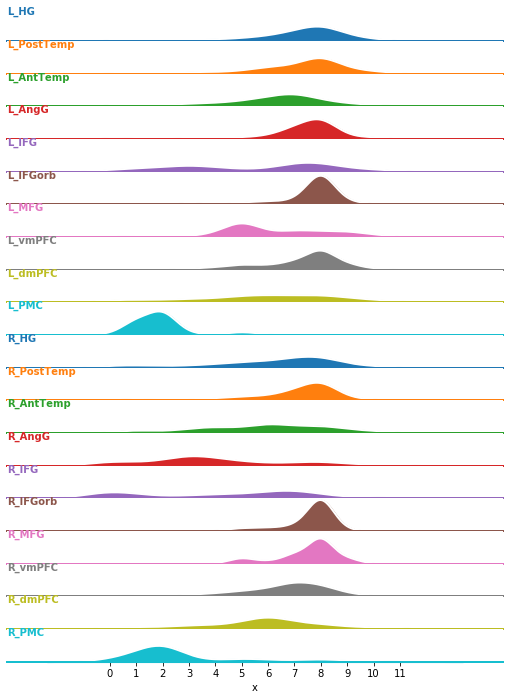

In [44]:

make_ridge_plot(zwise,tau=3.0)
